Sarah Wigodsky
Data 608 Module 2

Techniques for dealing with big data -  
In this module, I used binning strategies and the datashader library.
To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.

In [23]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy


from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

from functools import partial

from IPython.display import GeoJSON

In [2]:
bk = pd.read_csv('BK_18v1.csv')
bx = pd.read_csv('BX_18v1.csv')
mn = pd.read_csv('MN_18v1.csv')
qn = pd.read_csv('QN_18v1.csv')
si = pd.read_csv('SI_18v1.csv')

ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True)

# Getting rid of some outliers
ny = ny[(ny['YearBuilt'] > 1850) & (ny['YearBuilt'] < 2020) & (ny['NumFloors'] != 0)]

C:\Users\Sarah.Wigodsky\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning:

Columns (19,20,22,23,24,25,26,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.

C:\Users\Sarah.Wigodsky\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning:

Columns (19,20,22,23,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.

C:\Users\Sarah.Wigodsky\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning:

Columns (20,23,24,26,64) have mixed types. Specify dtype option on import or set low_memory=False.

C:\Users\Sarah.Wigodsky\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning:

Columns (19,20,22,23,64,65,77) have mixed types. Specify dtype option on import or set low_memory=False.

C:\Users\Sarah.Wigodsky\AppData\Local\Continuum\anaco

In [3]:
wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
ny['XCoord'] = 0.3048*ny['XCoord']
ny['YCoord'] = 0.3048*ny['YCoord']
ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['XCoord'].values, ny['YCoord'].values)

ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

Part 1: Binning and Aggregation¶ 

Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and 2D histograms (also check out their close relatives: 2D density plots and the more general form: heatmaps.
While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [4]:
#tools.set_credentials_file(username='', api_key='')
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('YearBuilt').count()['BBL'].index,
    y = ny.groupby('YearBuilt').count()['BBL']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.Figure(data = [trace], layout = layout)

py.iplot(fig, filename = 'ny-year-built')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~swigodsky/0 or inside your plot.ly account where it is named 'ny-year-built'


Question¶ 
After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

In [5]:
numfloors_df = ny[['YearBuilt','NumFloors']]
numfloors_df.head
numfloors_df.dropna(how='any')
len(numfloors_df)

811134

The following table shows the year built for buildings sorted by the number of floors from least to greatest.  The lowest number of floors is 0.5.

In [6]:
numfloors_df.sort_values(by=['NumFloors','YearBuilt'], ascending=[True,True]).head(10)

,YearBuilt,NumFloors
611073,1920,0.5
304949,2007,0.5
38405,1855,1.0
38448,1855,1.0
837,1860,1.0
9230,1866,1.0
380318,1870,1.0
607324,1874,1.0
422954,1875,1.0
602120,1879,1.0


The following table shows the year built for buildings sorted by the number of floors from greatest to least.  The largest number of floors is 119.  There are 6 buildings with 90 floors or more.

In [7]:
numfloors_df.sort_values(by=['NumFloors','YearBuilt'], ascending=[False,True]).head(10)

,YearBuilt,NumFloors
82436,2008,119.0
802762,2003,114.0
367464,2009,104.0
380811,1931,102.0
368380,1940,90.0
389346,2012,90.0
383879,2013,88.0
383884,2013,88.0
383885,2013,88.0
383886,2015,88.0


I am creating bins to categorize the number of stories.  Because there are so few buildings with more than 70 floors, the range for the bins for larger numbers of floors is larger.  Bins of 10 stories are used up through 70 floors, then a bin of 20 stories for buildings between 71-90 stories and then a bin of 30 stories for buildings between 91-120 floors.

In [8]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 90, 120]
group_names = ['.5-10 floors','11-20 floors', '21-30 floors', '31-40 floors', '41-50 floors', '51-60 floors', '61-70 floors', '71-90 floors', '91-120 floors']
numfloors_df['FloorRange'] = pd.cut(numfloors_df['NumFloors'], bins, labels=group_names)
numfloors_df.head(10)

C:\Users\Sarah.Wigodsky\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,YearBuilt,NumFloors,FloorRange
1,1920,10.0,.5-10 floors
16,1988,1.0,.5-10 floors
19,1920,1.0,.5-10 floors
21,1900,7.0,.5-10 floors
22,1911,11.0,11-20 floors
23,1977,1.0,.5-10 floors
24,1920,5.0,.5-10 floors
25,1900,2.0,.5-10 floors
26,1910,4.0,.5-10 floors
27,1910,6.0,.5-10 floors


The following table shows the number of buildings built each year within each range of height.

In [9]:
floorRange_df = numfloors_df.drop('NumFloors', 1)
floorRange = floorRange_df.groupby('YearBuilt')['FloorRange'].value_counts().to_frame(name='Count').reset_index()
floorRange.head(10)

,YearBuilt,FloorRange,Count
0,1851,.5-10 floors,8
1,1852,.5-10 floors,14
2,1853,.5-10 floors,11
3,1853,11-20 floors,1
4,1854,.5-10 floors,6
5,1855,.5-10 floors,14
6,1856,.5-10 floors,11
7,1857,.5-10 floors,8
8,1858,.5-10 floors,8
9,1859,.5-10 floors,10


In [10]:
floorRange.columns

Index(['YearBuilt', 'FloorRange', 'Count'], dtype='object')

Pivot the data table so that each bin containing the number of stories is a distinct column.

In [11]:
floorCount = floorRange.pivot(index='YearBuilt', columns='FloorRange', values='Count').reset_index()
floorCount.head(5)

FloorRange,YearBuilt,.5-10 floors,11-20 floors,21-30 floors,31-40 floors,41-50 floors,51-60 floors,61-70 floors,71-90 floors,91-120 floors
0,1851,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1852,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1853,11.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1854,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1855,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
floorCount.columns

Index(['YearBuilt', '.5-10 floors', '11-20 floors', '21-30 floors',
       '31-40 floors', '41-50 floors', '51-60 floors', '61-70 floors',
       '71-90 floors', '91-120 floors'],
      dtype='object', name='FloorRange')

In [13]:
data = [go.Bar(
    y = floorCount['.5-10 floors'],
    x = floorCount['YearBuilt'],      
    )]

layout = go.Layout(
    title='Number of 0-10 Floor Buildings Built',
    xaxis=dict(
        title='Year Built'
    ),
    yaxis=dict(
        title='Number of 0-10 Floor Buildings Built'
    ),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

The previous bar graph shows the number of buildings of 0-10 floors that are built each year.  It is a curious graph as it shows signifciantly higher numbers of buildings built every 5 years from 1905 through 1980.  Perhaps this has more to do with the recording of data on 5 year intervals rather than the actual trend in building.  Still, there is clearly a peak in the number of small buildings built from 1920 through 1930.

In [14]:
data = [go.Bar(
    y = floorCount['41-50 floors'],
    x = floorCount['YearBuilt'],      
    )]

layout = go.Layout(
    title='Number of 41-50 Floor Buildings Built',
    xaxis=dict(
        title='Year Built'
    ),
    yaxis=dict(
        title='Number of 41-50 Floor Buildings Built'
    ),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

The previous graph displays the number of buildings with floors between 41 and 50 floors that were built in NYC.  No buildings of this size were built before 1909 and only 5 were built through 1926.  There was a spike in the number of 41-50 story buildings built in 1987.

In [15]:
data = [go.Bar(
    y = floorCount['91-120 floors'],
    x = floorCount['YearBuilt'],      
    )]

layout = go.Layout(
    title='Number of 91-120 Floor Buildings Built',
    xaxis=dict(
        title='Year Built'
    ),
    yaxis=dict(
        title='Number of 91-120 Floor Buildings Built'
    ),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

When looking at the tallest buildings, that is those between 91 and 120 stories, there was one in 1931 and then 4 in the early 2000s.

In [16]:
trace1 = go.Bar(
    y = floorCount['21-30 floors'],
    x = floorCount['YearBuilt'],
    name='21-30 Floors'
)
trace2 = go.Bar(
    y = floorCount['11-20 floors'],
    x = floorCount['YearBuilt'],
    name='11-20 Floors'
)

trace3 = go.Bar(
    y = floorCount['31-40 floors'],
    x = floorCount['YearBuilt'],
    name='31-40 Floors'
)

data = [trace2, trace1, trace3]
layout = go.Layout(
    barmode='group',
    title='Number of Buildings Built in New York City 1851-2018',
    xaxis=dict(
        title='Year Built'
    ),
    yaxis=dict(
        title='Number of Buildings Built'
    ),
)    


fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

The previous graph displays the number of buildings built in 3 different ranges of height.  There are a relative low number of buildings of this size built bewteen 1932 and 1948.  There is another dip in the number of 11-40 story buildings built bewteen 1990 and 1998.  The different size buildings tend to follow a similar building trend, with buildings of the lower number of floors being more prevelant.

Part 2: Datashader
Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [17]:
yearbins = 200
floorbins = 200

yearBuiltCut = pd.cut(ny['YearBuilt'], np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['NumFloors'], np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))

xlabels = np.floor(np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))

data = [
    go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['BBL'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)
]

py.iplot(data, filename = 'datashader-2d-hist')

Plot in Datashader:

C:\Users\Sarah.Wigodsky\AppData\Local\Continuum\anaconda3\lib\site-packages\datashader\transfer_functions.py:162: RuntimeWarning:

invalid value encountered in log1p



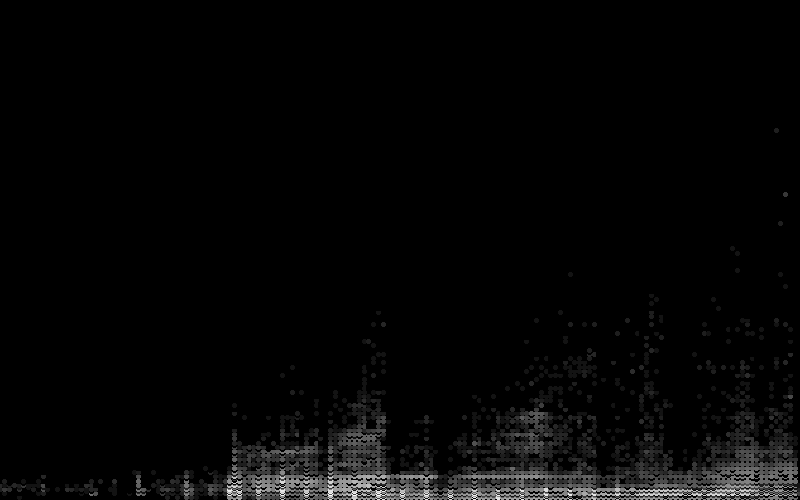

In [18]:
ny_graph1 = ny[['YearBuilt', 'NumFloors']]
cvs = ds.Canvas(800, 500, x_range = (ny_graph1['YearBuilt'].min(), ny_graph1['YearBuilt'].max()), 
                                y_range = (ny_graph1['NumFloors'].min(), ny_graph1['NumFloors'].max()))
agg = cvs.points(ny_graph1, 'YearBuilt', 'NumFloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

C:\Users\Sarah.Wigodsky\AppData\Local\Continuum\anaconda3\lib\site-packages\datashader\transfer_functions.py:162: RuntimeWarning:

invalid value encountered in log1p



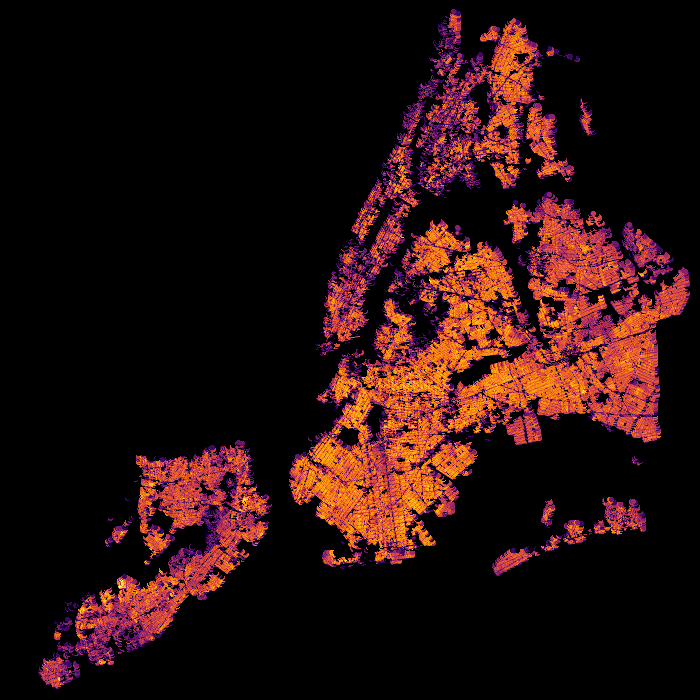

In [19]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Question
You work for a real estate developer and are researching underbuilt areas of the city. After looking in the Pluto data dictionary, you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about bivariate choropleth maps, and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

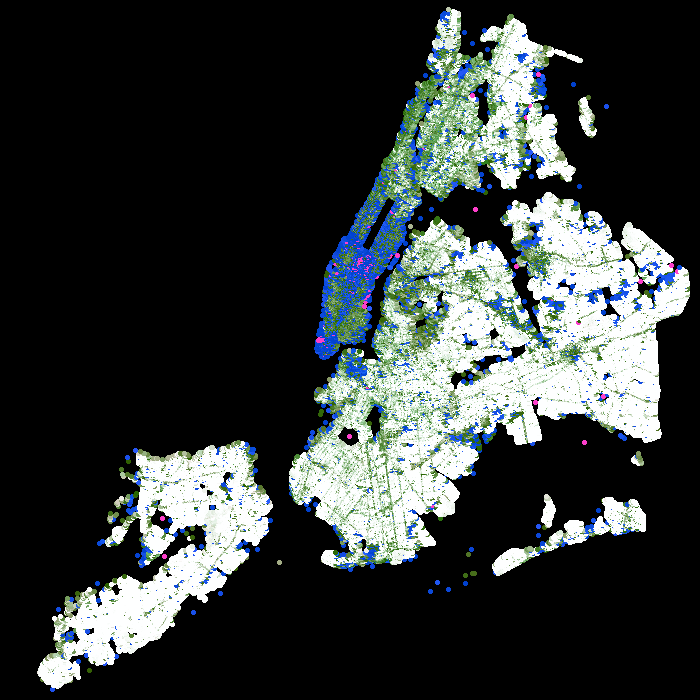

In [20]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat', ds.mean('AssessTot'))
view1 = tf.shade(agg, cmap = ['white','green'])
agg = cvs.points(ny, 'lon', 'lat', ds.mean('AssessLand'))
view2 = tf.shade(agg, cmap = ['white','pink'])
export(tf.spread(view1+view2, px=2), 'nyc')

The above graph uses a range of colors from white to green to represent the intensity of the total value of the structure.
The total value of the land is represented by a range of colors from white to pink.  

The overall result is that locations where the structure's value and the land's value are both low are white.  This occurs through much of Staten Island, the parts of Brooklyn that are not on the northern edge, much of Queens and the eastern region of the Bronx.  These areas are built in a way that the property values are correlated with the land values.

Locations where the property's value is high and the land's value is high are blue.This occurs in Midtown Manhattan down to the Battery and are largely at the shore line of Manhattan, the shoreline of Staten Island and some pockets in the center of Brooklyn and Queens.   These areas are built in a way that the property values are correlated with the land values.

Locations where the property's value is high but the land's value is low are green.  This occurs in upper Manhattan, the western Bronx, pockets in Brooklyn and Queens and parts of the western coast of Staten Island.  These locations are overbuilt.

Locations where the land's value is high and the property's value is low are pink. There are not many locations where the property values are low and the land values are high.  However they do exist in small sections in each of the boroughs.  These locations are underbuilt, and I would recommend building and investing there.